.. note::
   To download the tutorial data, use the following commands:

   **All tutorial data:**
   ```python
   from recon.data import fetch_all_tutorial_data
   fetch_all_tutorial_data(data_dir='./data')
   ```

   **Specific file (e.g., RNA data):**
   ```python
   from recon.data import fetch_tutorial_data
   fetch_tutorial_data('perturbation_tuto/rna.h5ad', data_dir='./data')
   ```

# Understanding Multicellular Programs with ReCoN

This tutorial demonstrates how to use ReCoN to explore **multicellular coordination** around a pathway of interest. You will learn how to:

1. Build a multilayer network integrating GRNs and cell-cell communication
2. Define seed genes (e.g., from a pathway or differential expression)
3. Run Random Walk with Restart (RWR) to identify upstream regulators
4. Interpret the results as cell-type-specific gene profiles

**Use case**: Given a pathway activated in one cell type (e.g., TNF-α signaling in macrophages), identify which signals from neighboring cells may have triggered this activation.

---

## Setup

ReCoN uses single-cell RNA-seq data to infer cell-cell communication and gene regulatory networks.

```{tip}
The example data for this tutorial can be downloaded from the [ReCoN repository](https://github.com/cantinilab/ReCoN/tree/main/data/perturbation_tuto).
```

```{note}
**Required packages**

This tutorial requires `gseapy` for gene set enrichment and `liana` for cell-cell communication:
- Install with: `pip install gseapy liana`
- **Important**: `gseapy` requires `lxml` to download gene sets from MSigDB. Install it with: `pip install lxml`
```

In [5]:
import numpy as np
import scanpy as sc
import pandas as pd
import liana as li
import gseapy as gp
from gseapy import Msigdb

import recon
import recon.data
import recon.explore

In [6]:
# Load example scRNA-seq data
rna = sc.read_h5ad("./data/perturbation_tuto/rna.h5ad")

In [7]:
# Check available cell types
rna.obs["celltype"].unique().tolist()

['B_cell',
 'ILC',
 'Macrophage',
 'MigDC',
 'Monocyte',
 'NK_cell',
 'Neutrophil',
 'T_cell_CD4',
 'T_cell_CD8',
 'T_cell_gd',
 'Treg',
 'cDC1',
 'cDC2',
 'eTAC',
 'pDC']

---

## Build the Multilayer Network

ReCoN integrates three main components:
1. **Gene Regulatory Networks (GRNs)** - TF → target gene relationships
2. **Cell-Cell Communication (CCC)** - Ligand-receptor interactions between cell types
3. **Receptor-Gene Links** - How receptors connect to intracellular signaling

### 1. Import Gene Regulatory Network

You can either generate GRNs directly with ReCoN or import a previously generated one.

```{tip}
If you wish to generate GRNs directly with ReCoN, please follow [Tutorial 4: GRN Inference with HuMMuS](4.recon_hummus.ipynb).
```

```{warning}
GRN inference requires a **Python 3.10** conda environment due to CellOracle dependencies. See the [Installation guide](../recon_explained/get_ready.rst) for details.
```

In [8]:
# Load pre-computed GRN (or generate with ReCoN - see Tutorial 4)
grn_path = "./data/perturbation_tuto/grn.csv"
grn = pd.read_csv(grn_path)
grn = grn.sort_values(by="weight", ascending=False)[:500_000]
grn["source"] = grn["source"].str.capitalize()
grn["source"] = grn["source"] + '_TF'
grn["target"] = grn["target"].str.capitalize()
grn.head(3)

,Unnamed: 0,target,source,weight
0,0,Pax5,Mbd1_TF,0.000095
2,2,Pax5,Smad5_TF,0.000092
1,1,Pax5,Smad1_TF,0.000092


### 2. Compute Cell-Cell Communication

The cell-cell communication is inferred through LIANA+, an external package dedicated to this task.

```{tip}
For more information, check the [LIANA+ documentation](https://liana-py.readthedocs.io/en/latest/).
```

In [9]:
li.method.cellphonedb(rna, 
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name="mouseconsensus",
            expr_prop=0.00,
            use_raw=False,
            groupby="celltype",
            verbose=True, key_added='cpdb_res')


Using resource `mouseconsensus`.
Using `.X`!
/pasteur/appa/homes/rtrimbou/miniconda3/envs/snakemake/envs/recon-grn/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
15364 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!


/pasteur/appa/homes/rtrimbou/miniconda3/envs/snakemake/envs/recon-grn/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/pasteur/appa/homes/rtrimbou/miniconda3/envs/snakemake/envs/recon-grn/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.36 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 1296 samples and 937 features


100%|██████████| 1000/1000 [00:04<00:00, 228.37it/s]


Format the LIANA output for ReCoN (rename columns to standard format):

In [10]:
ccc_network = rna.uns["cpdb_res"].copy()
ccc_network = ccc_network[["ligand", "receptor", "lr_means", "source", "target"]]
ccc_network = ccc_network.rename(columns={
    "lr_means": "weight",
    "source": "celltype_source",
    "target": "celltype_target",
    "ligand": "source",
    "receptor": "target"
})
ccc_network = ccc_network[ccc_network['weight'] != 0]

### 3. Load Receptor-Gene Links

These links connect membrane receptors to downstream target genes in the GRN.

In [11]:
# Load receptor-gene links from NicheNet prior knowledge
receptor_genes = recon.data.load_data.load_receptor_genes("mouse_receptor_gene_from_NichenetPKN")

# Filter to genes present in our GRN
genes = np.unique(grn['source'].tolist() + grn['target'].tolist())
receptor_genes = receptor_genes[receptor_genes['target'].isin(genes)]
receptor_genes.head()

,source,target,weight
2,A1bg,Abca1,0.005156
3,A1bg,Abcb1a,0.005877
4,A1bg,Abcb1b,0.005877
7,A1bg,Acsl1,0.005915
8,A1bg,Adk,0.005092


---

## Define Seed Genes

Seeds are the genes of interest that define your biological question. ReCoN will explore the network to find regulators (upstream) or targets (downstream) of these seeds.

**Example**: We use the TNF-α signaling via NF-κB hallmark gene set, hypothetically activated in macrophages.

In [15]:
import gseapy as gp
from gseapy import Msigdb 

# we can use gseapy to download the hallmarks from MSigDB
msig = Msigdb()
hallmarks = msig.get_gmt(category='mh.all', dbver="2024.1.Mm")
print(f"Available hallmarks: {list(hallmarks.keys())[:5]}...")

# Select TNF-α signaling pathway and filter to genes in our network
gene_seeds = [gene for gene in hallmarks['HALLMARK_TNFA_SIGNALING_VIA_NFKB'] if gene in genes]
print(f"\nFiltered seeds: {len(gene_seeds)} genes from hallmark")

# Create seed dictionary with equal weights (all genes equally important)
gene_seeds = {seed: 1 for seed in gene_seeds}

Available hallmarks: ['HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION']...

Filtered seeds: 157 genes from hallmark


Now we need to assign seeds to a specific **cell type**. Since we're investigating TNF-α signaling activated in macrophages, we add the `::Macrophage` suffix to each gene:

In [16]:
# Format seeds for ReCoN: gene::celltype
# This tells ReCoN that these genes are activated specifically in Macrophages
seeds = {f"{gene}::Macrophage": score for gene, score in gene_seeds.items() if score > 0}

print(f"Example seeds: {dict(list(seeds.items())[:3])}")

Example seeds: {'Abca1::Macrophage': 1, 'Atf3::Macrophage': 1, 'Atp2b1::Macrophage': 1}


```{warning}
**Node naming conventions in ReCoN**

Molecules are named differently depending on the layer:
- **Intracellular layers** (GRN): `gene::celltype` with double colons (e.g., `Nfkb1::Macrophage`)
- **Extracellular layer** (CCC): `ligand-celltype` with hyphen (e.g., `Tnf-Macrophage`)

These suffixes are added automatically when building the network - do NOT add them manually to your input DataFrames.
```

```{note}
**Using custom gene sets**

You can use your own gene sets as seeds, for example from differential expression analysis:
- Filter genes to keep only those present in your network
- Assign different weights to genes (e.g., based on logFC or confidence)
- ⚠️ **All gene weights must be positive!**
```

---

## Assemble the Multicellular Network

Now we build the `Multicell` object that integrates GRNs, receptor-gene links, and cell-cell communication across all cell types.

```{tip}
**Key parameters to customize**

- `restart_proba`: Controls exploration depth (higher = stay closer to seeds)
- `ccc_proba`: Balance between intracellular (GRN) and intercellular (CCC) exploration
- `grn_graph_directed/weighted`: How GRN edges are interpreted
- `cell_communication_graph_directed/weighted`: How CCC edges are interpreted
```

In [17]:
# Network parameters
cell_communication_graph_directed = False
cell_communication_graph_weighted = True
grn_graph_directed = False
grn_graph_weighted = True

# RWR parameters
restart_proba = 0.6  # Higher = stay closer to seeds
ccc_proba = 0.5      # Balance GRN vs CCC exploration

In [18]:
# Define cell types to include
celltypes = ["B_cell", "pDC", "Macrophage", "NK_cell", "T_cell_CD4", "T_cell_CD8"]

# Build the Multicell network
generic_multicell = recon.explore.Multicell(
    celltypes={
        celltype: recon.explore.Celltype(
            grn_graph=grn,
            receptor_grn_bipartite=receptor_genes,
            celltype_name=celltype,
            receptor_graph_directed=False,
            receptor_graph_weighted=False,
            grn_graph_directed=grn_graph_directed,
            grn_graph_weighted=grn_graph_weighted,
            receptor_grn_bipartite_graph_directed=False,
            receptor_grn_bipartite_graph_weighted=True,
            seeds=seeds
        )
        for celltype in celltypes
    },
    cell_communication_graph=ccc_network[
        ccc_network["celltype_source"].isin(celltypes) & 
        ccc_network["celltype_target"].isin(celltypes)
    ],
    cell_communication_graph_directed=cell_communication_graph_directed,
    cell_communication_graph_weighted=cell_communication_graph_weighted,
    bipartite_grn_cell_communication_directed=False,
    bipartite_grn_cell_communication_weighted=False,
    bipartite_cell_communication_receptor_directed=False,
    bipartite_cell_communication_receptor_weighted=False,
    seeds=seeds,
)

/pasteur/helix/projects/ml4ig_hot/Users/rtrimbou/ReCoN/src/recon/explore/recon.py:122: UserWarning: 
                No receptor_graph provided,
                an empty receptor graph will be created.
                
/pasteur/helix/projects/ml4ig_hot/Users/rtrimbou/ReCoN/src/recon/explore/recon.py:387: UserWarning: The celltypes dictionary was converted toa list of Celltype objects.
The keys of the dictionary will be the celltype names.


---

## Configure Exploration Direction

ReCoN allows you to explore the network in different directions:
- **upstream**: Find regulators that may have activated your seed genes
- **downstream**: Find targets that may be affected by your seed genes

And with different strategies:
- **intracell**: Explore only within the GRN (no cell-cell communication)
- **intercell**: Explore both GRN and cell-cell communication

In [19]:
# Set lambda transition matrix for upstream intercellular exploration
generic_multicell.lamb = recon.explore.set_lambda(
    generic_multicell,
    direction="upstream",   # Look for upstream regulators
    strategy="intercell",   # Include cell-cell communication
)

```{tip}
Alternatively, you can modify lambda transition probabilities freely, to modulate GRN and CCC exploration
```

In [20]:
# layers = generic_multicell.lamb.index
# is_grn = layers.str.endswith("_grn")
# generic_multicell.lamb.loc[is_grn, is_grn] = generic_multicell.lamb.loc[is_grn, is_grn]
# generic_multicell.lamb.loc[is_grn, "cell_communication"] = generic_multicell.lamb.loc[is_grn, "cell_communication"]*1
generic_multicell.lamb

,cell_communication,B_cell_receptor,B_cell_grn,pDC_receptor,pDC_grn,Macrophage_receptor,Macrophage_grn,NK_cell_receptor,NK_cell_grn,T_cell_CD4_receptor,T_cell_CD4_grn,T_cell_CD8_receptor,T_cell_CD8_grn
cell_communication,0.142857,0.0,0.142857,0.0,0.142857,0.0,0.142857,0.0,0.142857,0.0,0.142857,0.0,0.142857
B_cell_receptor,0.500000,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
B_cell_grn,0.000000,0.5,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
pDC_receptor,0.500000,0.0,0.000000,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
pDC_grn,0.000000,0.0,0.000000,0.5,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
Macrophage_receptor,0.500000,0.0,0.000000,0.0,0.000000,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
Macrophage_grn,0.000000,0.0,0.000000,0.0,0.000000,0.5,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000
NK_cell_receptor,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.5,0.000000,0.0,0.000000,0.0,0.000000
NK_cell_grn,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.5,0.500000,0.0,0.000000,0.0,0.000000
T_cell_CD4_receptor,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.5,0.000000,0.0,0.000000


---

## Run Random Walk with Restart

```{note}
The RWR algorithm explores the multilayer network starting from seed genes, propagating scores to identify the most relevant upstream regulators or downstream targets.
```

In [21]:
# Create multiXrank object
multilayer = generic_multicell.Multixrank(
    restart_proba=restart_proba
)

# Run random walk with restart
results = multilayer.random_walk_rank()

Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
cell_communication
receptor
gene
receptor
gene
receptor
gene
receptor
gene
receptor
gene
receptor
gene
Identifying produced ligands in response to the perturbation.


In [22]:
results

,multiplex,node,layer,score
0,cell_communication,Abca1-B_cell,cell_communication,9.980243e-07
1,cell_communication,Abca1-Macrophage,cell_communication,1.452575e-05
2,cell_communication,Abca1-NK_cell,cell_communication,8.732993e-07
3,cell_communication,Abca1-T_cell_CD4,cell_communication,6.532287e-07
4,cell_communication,Abca1-T_cell_CD8,cell_communication,8.411035e-07
...,...,...,...,...
10523,T_cell_CD8_grn,Zxdc::T_cell_CD8,gene,5.749365e-11
10524,T_cell_CD8_grn,Zyg11b::T_cell_CD8,gene,5.351816e-11
10525,T_cell_CD8_grn,Zyx::T_cell_CD8,gene,1.311222e-10
10526,T_cell_CD8_grn,Zzef1::T_cell_CD8,gene,4.733255e-10


In [23]:
# Format results as gene profiles per cell type
cell_type_profiles = recon.explore.format_multicell_results(
    multicell_multixrank_results=results,
    celltypes=celltypes,
    keep_layers="gene"
)

cell_type_profiles.head()

/pasteur/helix/projects/ml4ig_hot/Users/rtrimbou/ReCoN/src/recon/explore/recon.py:588: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/pasteur/helix/projects/ml4ig_hot/Users/rtrimbou/ReCoN/src/recon/explore/recon.py:588: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


celltype,B_cell,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8,pDC
gene,,,,,,
A3galt2,3.732416e-12,6.487802e-08,2.199377e-11,1.066063e-11,1.136353e-12,1.582009e-12
A4galt,2.506706e-11,4.022829e-07,2.572855e-11,1.230480e-11,1.225733e-11,1.894137e-11
Aa467197,1.810938e-11,7.258679e-07,7.255790e-11,5.224209e-11,4.171843e-11,3.586100e-11
Aaas,4.564902e-11,2.528730e-06,8.919788e-11,7.891676e-11,5.634262e-11,1.073224e-10
Aacs,1.611731e-10,6.068169e-06,3.717980e-10,2.366377e-10,1.864389e-10,2.695307e-10


---

## Interpret Results

The results show RWR scores for each gene in each cell type. Higher scores indicate genes more strongly connected to your seeds through the multilayer network.

```{tip}
You can use these cell-type-specific gene profiles for:
- **Gene set enrichment analysis** to identify activated pathways per cell type
- **Visualization** with Sankey diagrams (see [Tutorial 3](3.recon_molecular_cascades.ipynb))
- **Comparison** between conditions or treatments
```

### Visualize Top Genes per Cell Type

In [24]:
cell_type_profiles

celltype,B_cell,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8,pDC
gene,,,,,,
A3galt2,3.732416e-12,6.487802e-08,2.199377e-11,1.066063e-11,1.136353e-12,1.582009e-12
A4galt,2.506706e-11,4.022829e-07,2.572855e-11,1.230480e-11,1.225733e-11,1.894137e-11
Aa467197,1.810938e-11,7.258679e-07,7.255790e-11,5.224209e-11,4.171843e-11,3.586100e-11
Aaas,4.564902e-11,2.528730e-06,8.919788e-11,7.891676e-11,5.634262e-11,1.073224e-10
Aacs,1.611731e-10,6.068169e-06,3.717980e-10,2.366377e-10,1.864389e-10,2.695307e-10
...,...,...,...,...,...,...
Zxdc,5.093798e-11,3.639593e-06,9.350631e-11,5.937546e-11,5.749365e-11,1.114977e-10
Zyg11b,4.335809e-11,1.976685e-06,1.224202e-10,7.326363e-11,5.351816e-11,7.207313e-11
Zyx,1.159371e-10,4.382442e-06,2.812427e-10,1.871071e-10,1.311222e-10,2.306348e-10


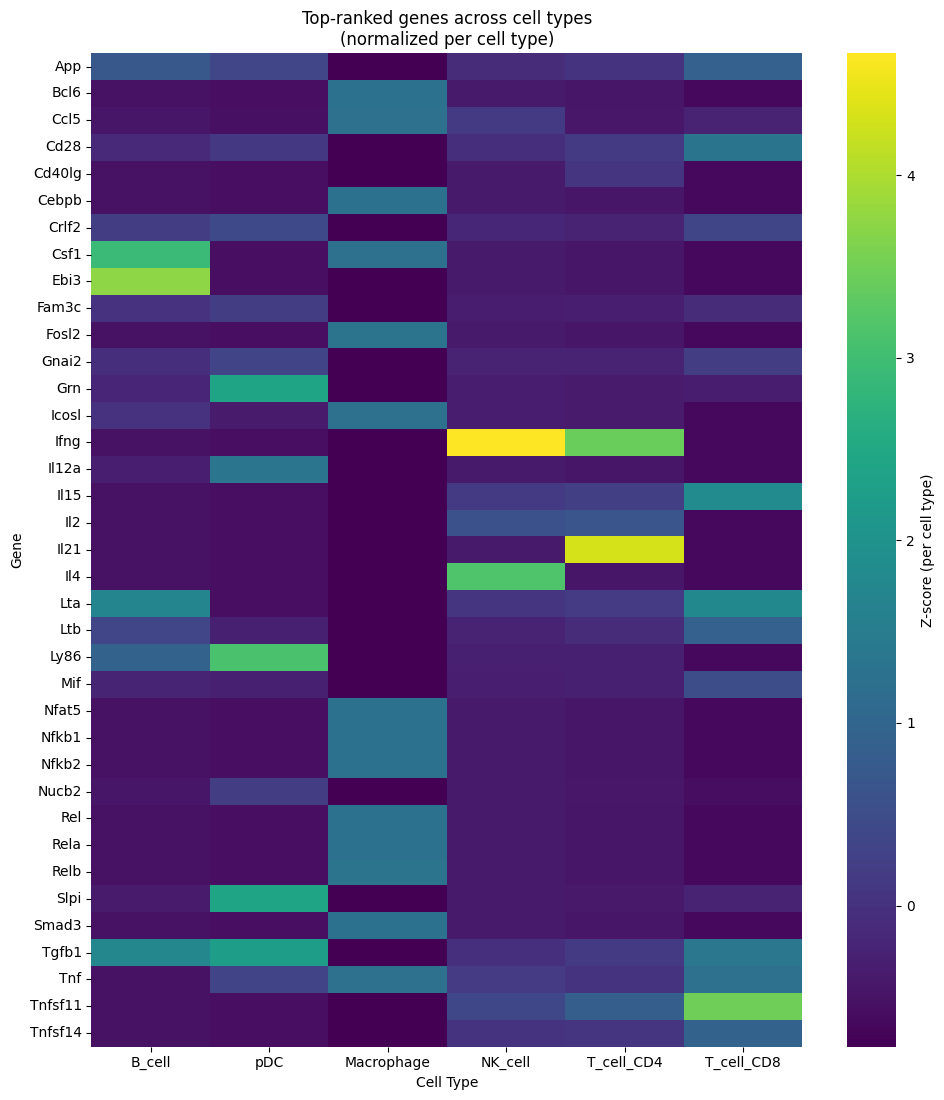

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check if 'gene' is a column or the index
if 'gene' not in cell_type_profiles.columns:
    cell_type_profiles = cell_type_profiles.reset_index().rename(columns={'index': 'gene'})

# Get top 10 genes per cell type
n_top = 10
top_genes_per_celltype = {}
for ct in celltypes:
    if ct in cell_type_profiles.columns:
        top_genes_per_celltype[ct] = cell_type_profiles.nlargest(n_top, ct)[['gene', ct]]

# Create a combined view: heatmap of top genes across all cell types
all_top_genes = list(set([g for ct in top_genes_per_celltype for g in top_genes_per_celltype[ct]['gene'].tolist()]))
available_celltypes = [ct for ct in celltypes if ct in cell_type_profiles.columns]
heatmap_data = cell_type_profiles[cell_type_profiles['gene'].isin(all_top_genes)].set_index('gene')[available_celltypes]

# Normalize per column (z-score) so each cell type has its own scale
heatmap_data_normalized = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()

# Plot heatmap with normalized values
fig, ax = plt.subplots(figsize=(10, max(6, len(all_top_genes) * 0.3)))
sns.heatmap(heatmap_data_normalized, cmap='viridis', ax=ax, cbar_kws={'label': 'Z-score (per cell type)'})
ax.set_title('Top-ranked genes across cell types\n(normalized per cell type)')
ax.set_xlabel('Cell Type')
ax.set_ylabel('Gene')
plt.tight_layout()
plt.show()

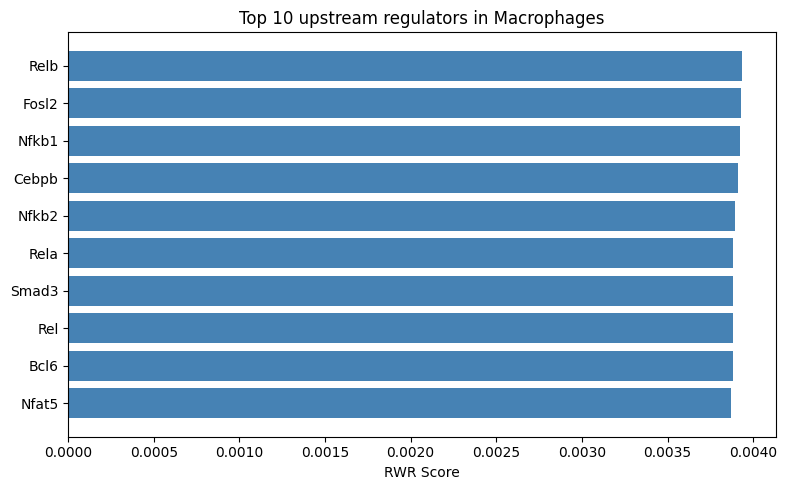

In [26]:
# Bar plot: Top 10 genes for the seed cell type (Macrophage)
fig, ax = plt.subplots(figsize=(8, 5))
if 'Macrophage' in cell_type_profiles.columns:
    top_macro = cell_type_profiles.nlargest(10, 'Macrophage')[['gene', 'Macrophage']]
    ax.barh(top_macro['gene'], top_macro['Macrophage'], color='steelblue')
    ax.set_xlabel('RWR Score')
    ax.set_title('Top 10 upstream regulators in Macrophages')
    ax.invert_yaxis()  # Highest at top
    plt.tight_layout()
    plt.show()
else:
    print("Macrophage not in results - check celltypes list")

### Compare Cell Type Contributions (excluding seed cell type)

Which **other** cell types contribute to upstream regulation? This reveals which neighboring cells may be sending signals to macrophages:

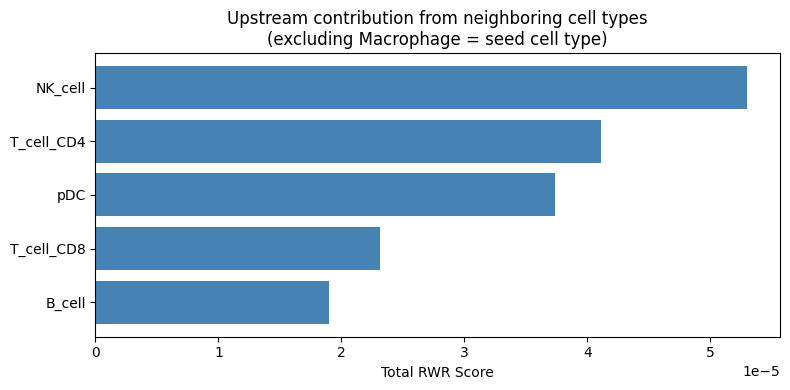

In [27]:
# Sum of RWR scores per cell type (excluding seed cell type Macrophage)
seed_celltype = 'Macrophage'
other_celltypes = [ct for ct in celltypes if ct in cell_type_profiles.columns and ct != seed_celltype]
celltype_totals = cell_type_profiles[other_celltypes].sum().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(celltype_totals.index, celltype_totals.values, color='steelblue')
ax.set_xlabel('Total RWR Score')
ax.set_title(f'Upstream contribution from neighboring cell types\n(excluding {seed_celltype} = seed cell type)')
plt.tight_layout()
plt.show()